In [12]:
import numpy as np
import cv2
import time
from contextlib import contextmanager

%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import widgets

import os
import sys
module_path = os.path.abspath(os.path.join('src'))
if module_path not in sys.path:
    sys.path.append(module_path)
sys.path.insert(0, '../')

from src.img_utils import (capture_screenshot, 
                           extract_object, 
                           extract_all_objects)
from src.key_mouse_utils import (move_to,
                                 click,
                                 scroll_up,
                                 scroll_down,
                                 drag,
                                 write,
                                 enter, hit_key,
                                 mouse_up, mouse_down)
from src.visual_bot import VisualBot

In [13]:
@contextmanager
def time_this():
    start = time.time()
    yield
    print(f"Time elapsed: {time.time()-start:.4f}")

In [14]:
def line_select_callback(eclick, erelease):
    'eclick and erelease are the press and release events'
    global bounding_boxes, gamebot
    x1, y1 = eclick.xdata, eclick.ydata
    x2, y2 = erelease.xdata, erelease.ydata
    x1, y1, x2, y2 = [round(x) for x in [x1, y1, x2, y2]]
    bounding_boxes.append((x1, y1))
    bounding_boxes.append((x2, y2))
    bounding_boxes.append([(x1, y1),(x2, y2)])
    gamebot.click(x1, y1)
    I = gamebot.capture_screenshot()
    # I = plt.imread()
    plt.imshow(I)
    plt.connect('key_press_event', toggle_selector)
    plt.show()
    
    # These will show in the notebook log (bottom left corner)
    print("(%3.2f, %3.2f) --> (%3.2f, %3.2f)" % (x1, y1, x2, y2))
    print(" The button you used were: %s %s" % (eclick.button, erelease.button))
    
def toggle_selector(event):
    print(' Key pressed.')
    if event.key in ['Q', 'q'] and toggle_selector.RS.active:
        print(' RectangleSelector deactivated.')
        toggle_selector.RS.set_active(False)
    if event.key in ['A', 'a'] and not toggle_selector.RS.active:
        print(' RectangleSelector activated.')
        toggle_selector.RS.set_active(True)

In [16]:
# for i in range(10):
#     template = plt.imread("../templates/donate_button.png")[...,:3]
#     bounding_box = extract_object(template, I)
#     click_bbox(bounding_box)
#     time.sleep(2)
#     print(bounding_box)
# template = plt.imread("../templates/return_button.png")[...,:3]
# bounding_box = extract_object(template, I)
# click_bbox(bounding_box)

In [17]:
gamebot = VisualBot(display=98)

Loading text_crop_model weights from checkpoint (../weights/craft_mlt_25k.pth)
Loading text_crop_model weights from checkpoint (/home/tung/pj/sel/deep-text-recognition-benchmark/weights/TPS-ResNet-BiLSTM-CTC.pth)


In [29]:
# gamebot.click(234, 28) #open new tab
# gamebot.click(206, 17) #close tab
# time.sleep(1)

# gamebot.click(473, 49)
# gamebot.write("https://espritgames.com/wartime/go/")
# gamebot.enter()
# time.sleep(10)

# gamebot.drag(1020, 350, 1020, 380)
# gamebot.click(477, 380)
# gamebot.drag(1020, 350, 1020, 380)
# gamebot.click(477, 380)
# time.sleep(10)

# click(657, 149)

# click(936, 241)
# click(583, 660)

# click(486, 489)
# write(credentials["email"])
# click(436, 537)
# write(credentials["password"])

# click(489, 618)

# click(727, 257)
# click(530, 627)
# scroll_down()

In [31]:
gamebot.drag(657, 123, 657, 280)
gamebot.click(657, 280)

In [37]:
%matplotlib widget
f, ax = plt.subplots(figsize=(8,7))
bounding_boxes = []
toggle_selector.RS = widgets.RectangleSelector(ax, line_select_callback,
                                       drawtype='box', useblit=True,
                                       button=[1, 3],  # don't use middle button
                                       minspanx=5, minspany=5,
                                       spancoords='pixels',
                                       interactive=True)

I = gamebot.capture_screenshot()
# I = plt.imread()

plt.imshow(I)
plt.connect('key_press_event', toggle_selector)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [38]:
# Get the most recently chosen bounding box
bounding_box = [[430,350], [457,375]] #bounding_boxes[-1]

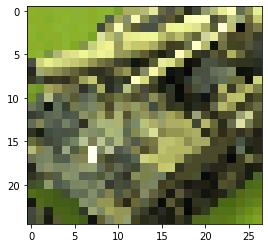

In [39]:
%matplotlib inline
template = I[bounding_box[0][1]:bounding_box[1][1], bounding_box[0][0]:bounding_box[1][0], :][:,:60,:]
# fig = plt.figure(frameon=False, facecolor='white')
# ax = plt.Axes(fig, [0., 0., 1., 1.])
# ax.set_axis_off()
# fig.add_axes(ax)
plt.imshow(template)
# plt.imsave('../templates/wut.png', template)
plt.show()

In [ ]:
name = "return_button"
# plt.imsave(f'../templates/{name}.png', template)

In [40]:
from skimage import color
color.colorconv.lab_ref_white = np.array([0.96422, 1.0, 0.82521])
template_lab = color.rgb2lab(template)

In [43]:
lab.max(), lab.min(), lab.mean(), lab.shape

(99.616875, -33.175797, 20.027157, (25, 27, 3))

In [ ]:
def extract_edges(img):    
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if np.max(img_gray) <= 1:
        img_gray = np.uint8(img_gray * 255)
    img_edges = cv2.Canny(img_gray,100,200)
    return img_edges

def extract_all_objects_(template, img, method=cv2.TM_SQDIFF_NORMED, 
                        mean_threshold=None, range_threshold=0.2):
    if mean_threshold == None:
        if method in [cv2.TM_SQDIFF_NORMED, cv2.TM_SQDIFF]:
            mean_threshold = 0.2
        else:
            mean_threshold = 0.8
    
    # Using each color channel
    h, w, _ = template.shape
    template = template[...,:3] # RGB only
    img = img[...,:3]
#     res_array = np.expand_dims(cv2.matchTemplate(img[:,:,0], template[:,:,0], method), 0)
#     for channel in range(1,3):
#         res = cv2.matchTemplate(img[:,:,channel], template[:,:,channel], method)
#         res_array = np.concatenate([res_array, np.expand_dims(res,0)], axis=0)
    
    # Using color diff
    
    
    # Using edges
    template_edges = extract_edges(template)
    img_edges = extract_edges(img)
    res = cv2.matchTemplate(img_edges, template_edges, method)
    res_array = np.concatenate([res_array, np.expand_dims(res,0)], axis=0)
        
    # Combine
    res_mean = 0.8*res_array[0] + 0.2*res_array[1]
    res_range = mean_threshold - np.min(res_array[:4,:,:], 0)
    
    if method in [cv2.TM_SQDIFF_NORMED, cv2.TM_SQDIFF]:
        loc = np.where( (res_mean <= mean_threshold) & (res_range <= range_threshold) )
    else:
        loc = np.where( (res_mean >= mean_threshold) & (res_range <= range_threshold) )

    bounding_boxes = [] # Each element contains top left and bottom right of a box
    for pt in zip(*loc[::-1]):
        top_left = pt
        bottom_right = (pt[0] + w, pt[1] + h)
        bounding_boxes.append([top_left, bottom_right])
        
    return bounding_boxes, res_array
            
def extract_all_objects(template, img, method=cv2.TM_SQDIFF_NORMED, 
                        mean_threshold=None, range_threshold=0.2):
    # Function need more work
    reses = []
    max_res = 0
    best_i = None
    chosen_boxes = []
    for i in range(2,15):
        h, w, _ = template.shape
        template_resized = cv2.resize(template, dsize=(w//i, h//i), interpolation=cv2.INTER_LINEAR)
        bounding_boxes, res = extract_all_objects_(template_resized, img, method=cv2.TM_CCOEFF_NORMED, 
                                                  mean_threshold=0.4,
                                                  range_threshold=0.2)
        chosen_boxes.extend(bounding_boxes)
        reses.append(res)
    chosen_boxes = filter_bounding_boxes(chosen_boxes)
    return chosen_boxes

In [ ]:
%matplotlib widget

# template = plt.imread("../templates/join_alliance_war_button.png")[...,:3]
with time_this():
    I_copy = I.copy()
#     bounding_boxes = extract_all_objects(template, I[I.shape[0]//2:,:,:])
#     for top_left, bottom_right in bounding_boxes:
#         cv2.rectangle(I_copy, top_left, bottom_right, 255, 2)
#     print(I.shape, template.shape, I.max(), template.max())
    bounding_box = extract_object(template, I)
    top_left, bottom_right = bounding_box
    cv2.rectangle(I_copy, top_left, bottom_right, 255, 2)
    plt.imshow(I_copy)

In [ ]:
bboxes = [((0, 0), (31, 29))]
%matplotlib widget

for bbox in bboxes:
#     bbox = gamebot.extract_text(I, "battle")[0]
    I_copy = I.copy()
    top_left, bottom_right = bbox
    cv2.rectangle(I_copy, top_left, bottom_right, 255, 2)
plt.imshow(I_copy)
plt.show()